# Data Analysis of Accidents in the USA
## by Maëlys, Natalia, Miguel

### Import Libraries

In [1]:
from dataanalysis.load import loading, splitting
from dataanalysis.preprocessing import missingvalues, outliertreatment, standardization, timedata
from dataanalysis.model import rfmodel
from dataanalysis.metrics import metrics
from dataanalysis.features import categoricalfeatures, heatfeatures, roadfeatures, statefeatures, timefeatures

### Load Data

In [2]:
# TARGET: predict severity of accident
data_path = './US_Accidents_March23_sample.csv'
df = loading.load_data(data_path)

### Preprocessing

1. remove NaN rows 
2. fill NaN with mean
3. binary 
4. outliers: winsorizing
5. (standardizing but this will done after feature engineering)

In [3]:
# handle missing values
df = missingvalues.drop_row_na(df, ['Temperature(F)', 'Humidity(%)', 'Pressure(in)',
                          'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)'])
df = missingvalues.fill_na_mean(df, ['Wind_Chill(F)', 'Precipitation(in)']) 

# binary dummy variable 
df = categoricalfeatures.binary_var(df, ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'])

# winsorize
df = outliertreatment.winsorize(df, 'Wind_Speed(mph)') 

### Features (minimum 5)

1. states **categorized** by region 
1. wind speed is **binned** in low, medium, high
1. heat index **calculation** based on math formulas and conditions 
1. farenheit to celsius **conversion** to understand the values better
1. length of an accident by **subtracting** datetime formats and **converting** to hours
1. month of accident by **extracting** value from datetime format
1. **sum** of roadway features

In [4]:
####### REGION: States have been transformed to a Region columns
####### categorization technique

### slight issue: 
df = statefeatures.state_to_region(df, 'State') 
df[['State', 'Region']].tail(5)

# one hot encoding
df = categoricalfeatures.one_hot_encoding(df, ['Region'])

In [5]:
####### BINNING WIND SPEED: continuous to categorical variable
####### binning technique

bins = [-1, 3, 7, 30]
labels = ['low', 'medium', 'high']
df = categoricalfeatures.binning(df, 'Wind_Speed(mph)', bins, labels)

# one hot encoding
df = categoricalfeatures.one_hot_encoding(df, ['Wind_Speed(mph)bin'])

In [6]:
####### HEAT INDEX EQUATION: based on temperature and humidity
####### math equation technique
df = heatfeatures.heat_index_f(df, 'Temperature(F)', 'Humidity(%)')

In [7]:
####### CONVERSION: we struggle to intrepret farenheit, so we will convert these to celsius
####### conversion technique
df = heatfeatures.temperature_conversion(df, ['Temperature(F)', 'Wind_Chill(F)', 'Heat_Index(F)'])
df[['Temperature(C)', 'Wind_Chill(C)', 'Heat_Index(C)']].head()

,Temperature(C),Wind_Chill(C),Heat_Index(C)
0,7.222222,7.222222,40.432024
1,17.777778,17.777778,16.028889
2,8.333333,8.333333,38.177873
3,7.222222,7.222222,30.877047
4,18.888889,18.888889,17.930000


In [8]:
####### LENGTH OF ACCIDENT: difference between start time and end time
####### difference technique
df = timedata.time_type(df, 'Start_Time')
df = timedata.time_type(df, 'End_Time')

df = timefeatures.time_difference(df, 'End_Time', 'Start_Time')

In [9]:
####### MONTH OF ACCIDENT: from start time
####### extraction technique
df = timefeatures.get_month(df, 'Start_Time')

In [10]:
####### SUM ROADWAY FEATURES: sum all booleans concerning road features
####### addition technique
road_feature_colnames = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
                         'No_Exit', 'Railway', 'Roundabout', 'Station',
                         'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
df = roadfeatures.road_feature_sum(df, road_feature_colnames)

In [11]:
# standardize 
df = standardization.standardize(df, ['Temperature(C)', 'Wind_Chill(C)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Precipitation(in)', 'Heat_Index(C)', 'Length_Time_Hours', 'Month_Start_Time', 'Road_Feature_Sum'])

# Model

In [12]:
features= [ 'Temperature(C)_standardized', 'Wind_Chill(C)_standardized',
            'Humidity(%)_standardized', 'Pressure(in)_standardized',
            'Visibility(mi)_standardized', 'Precipitation(in)_standardized',
            'Heat_Index(C)_standardized', 'Length_Time_Hours_standardized',
            'Month_Start_Time_standardized', 'Road_Feature_Sum_standardized',

            'Sunrise_Sunset_Night', 'Civil_Twilight_Night', 'Nautical_Twilight_Night', 'Astronomical_Twilight_Night',
            'Region_midwest', 'Region_northeast', 'Region_southeast', 'Region_southwest', 'Region_west', 
            'Wind_Speed(mph)bin_low', 'Wind_Speed(mph)bin_medium', 'Wind_Speed(mph)bin_high']

target= 'Severity'

# create subset of data with only relevant features
df = df[features + [target]] 

# train/test split
tr, te = splitting.split_data(df)

# Hyperparameter Tuning

In [13]:
rf_model = rfmodel.Model(target=target, feature=features, train=tr, test=te)

In [14]:
best_params = rf_model.randomized_param_tuning() # takes 1min5secs now

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5; total time=   1.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5; total time=   1.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   8.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   8.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   8.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  22.9s
[CV] END bootstrap=False, max_depth=90, max_features=

/Users/maelys/Desktop/bseenv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   4.9s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  10.2s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  10.5s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  10.5s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  10.2s
[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   2.9s
[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, max_features=lo

In [15]:
best_params

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [16]:
best_model = rfmodel.Model(target=target, feature=features, train=tr, test=te, params=best_params)

In [17]:
# train model and make test predictions
tr, te = best_model.model_predictions()

In [18]:
te.head()

,Temperature(C)_standardized,Wind_Chill(C)_standardized,Humidity(%)_standardized,Pressure(in)_standardized,Visibility(mi)_standardized,Precipitation(in)_standardized,Heat_Index(C)_standardized,Length_Time_Hours_standardized,Month_Start_Time_standardized,Road_Feature_Sum_standardized,...,Region_southwest,Region_west,Wind_Speed(mph)bin_low,Wind_Speed(mph)bin_medium,Wind_Speed(mph)bin_high,Severity,pred_1,pred_2,pred_3,pred_4
56468,1.394883,1.316027,-1.435991,0.407122,0.359975,-0.100481,-0.042919,-0.034843,0.862084,-0.621756,...,False,True,False,True,False,2,0.044949,0.729541,0.142281,0.083230
20376,1.068503,1.020465,0.358434,0.618252,0.359975,-0.100481,0.048863,-0.038481,0.216256,-0.621756,...,False,False,True,False,False,1,0.724315,0.089480,0.116490,0.069715
76030,1.068503,1.020465,-2.020222,-4.111056,0.359975,-0.100481,-0.217880,-0.035359,0.539170,-0.621756,...,False,True,False,False,True,2,0.053452,0.302661,0.331392,0.312496
25117,-1.700291,-2.073087,1.109589,0.626697,-2.948982,0.814399,1.433887,-0.019480,-0.752486,-0.621756,...,False,False,False,False,True,4,0.001429,0.149942,0.096808,0.751821
52682,0.415742,0.429340,-0.434451,0.567581,0.359975,-0.100481,-0.460632,-0.030549,-0.106658,-0.621756,...,False,True,False,True,False,4,0.011484,0.276815,0.094989,0.616712


# Performance Evaluation

In [19]:
f1_metric = metrics.F1_Score(target=target, feature=features, train=tr, test=te, model=best_model.model)
f1_result = f1_metric.calculate_metric()
print("F1 Metrics:")
f1_result

F1 Metrics:


{'f1 score train category 1': 0.9282524680109734,
 'f1 score train category 2': 0.9161921992231149,
 'f1 score train category 3': 0.8721573971552679,
 'f1 score train category 4': 0.9195066637671253,
 'f1 score test category 1': 0.8117986047922354,
 'f1 score test category 2': 0.5713971397139713,
 'f1 score test category 3': 0.463646328096456,
 'f1 score test category 4': 0.5862326043737573}

Confusion matrices:


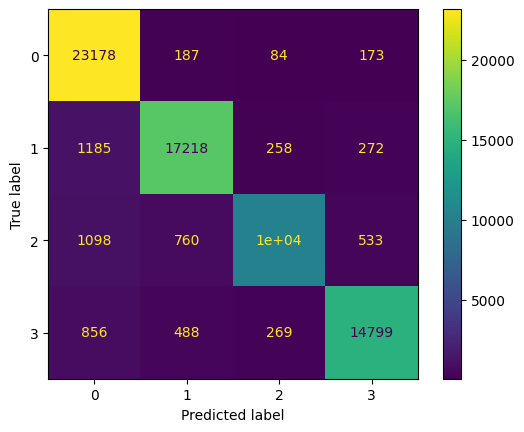

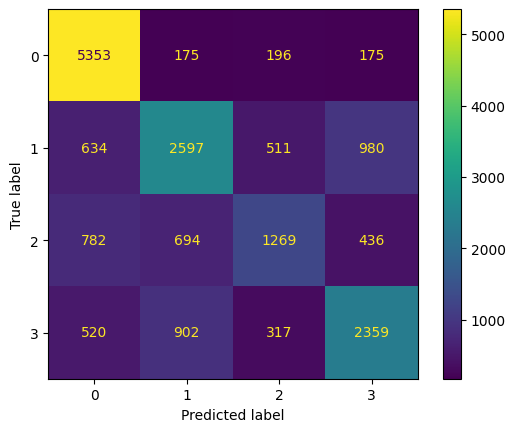

In [20]:
cm = metrics.ConfusionMatrix(target=target, feature=features, train=tr, test=te, model=best_model.model)
confusion_matrices = cm.calculate_metric()
print("Confusion matrices:")
cm.cm_display()
